In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.pyplot as plt

## Load Data

In [2]:
iris = load_iris()

In [3]:
Image_input = iris['data']
Image_input.shape

(150, 4)

In [4]:
Image_label = iris['target']
Image_label.shape

(150,)

## Split into train and test data

In [5]:
Train_X, Test_X, Train_Y, Test_Y = train_test_split(Image_input,
                                                    Image_label,
                                                    test_size=1/3,
                                                    random_state=1)

In [6]:
Train_X.shape, Test_X.shape

((100, 4), (50, 4))

## Standardise the data

In [7]:
Train_X_Norm = torch.from_numpy((Train_X - Train_X.mean())/Train_X.std()).to(torch.float32)
Train_Y = torch.from_numpy(Train_Y)

In [8]:
Train_X_Norm.shape, Train_Y.shape

(torch.Size([100, 4]), torch.Size([100]))

## Create Dataloader iterator

In [9]:
iris_data = TensorDataset(Train_X_Norm, Train_Y)
batch_size = 2
#torch.manual_seed(1)
data = DataLoader(iris_data, batch_size=batch_size, shuffle=True)

## Multilayer Perceptron Model

In [10]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x) # Dim=1 to apply softmax across column
        return x

In [11]:
input_size = Train_X_Norm.shape[1]
hidden_size = 16
output_size = 3
mlp = Model(input_size, hidden_size, output_size)
mlp

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

## Defining Loss function, Optimizer

In [12]:
loss_func = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = Adam(mlp.parameters(), lr=learning_rate)

## Training

In [13]:
epoch = 100
training_loss = [0] * epoch
training_accuracy = [0] * epoch

for i in range(epoch):
    for x_batch, y_batch in data:
        #print(y_batch.size(0))
        pred = mlp(x_batch)
        loss = loss_func(pred, y_batch) # pred is array of probabilities which is required by crossEntropy func
        loss.backward()
        optimizer.step() # Update parameters based on optimizer
        optimizer.zero_grad() # Reset gradients to 0 after every update
        training_loss[i] += loss.item() * y_batch.size(0)
        correct_count = (torch.argmax(pred, dim=1) == y_batch).to(torch.float32)
        training_accuracy[i] += correct_count.mean() * y_batch.size(0)
    training_loss[i] /= len(data.dataset)
    training_accuracy[i] /= len(data.dataset)
    if (i % 10 == 0):
        print(f"Epoch: {i+1}, Error: {loss}")
        
        

Epoch: 1, Error: 1.0750455856323242
Epoch: 11, Error: 0.7825888395309448
Epoch: 21, Error: 0.6911250948905945
Epoch: 31, Error: 0.8895916938781738
Epoch: 41, Error: 0.7234869003295898
Epoch: 51, Error: 0.6045358180999756
Epoch: 61, Error: 0.6305551528930664
Epoch: 71, Error: 0.6113092303276062
Epoch: 81, Error: 0.620545506477356
Epoch: 91, Error: 0.5991140604019165


### Reason for multiplying with 2 in accuracy and loss calculation in line 13 and 15

#### Nutshell - It is done to calculate average error properly for entire train data. CrossEntropyFunction(CE) gives mean error.

* Lets say you have total train data set size of 4
* Let batch size = 2

Inside for loop
* So for each iteration of for loop, you get 2 training data to be evaluated. (Batch1 = 2, Batch2 = 2, total 4 train data set)
* Hence loss1 = $2x_1$, where $x_1$ is loss for batch 1.
* Similarly, loss2 = $2x_2$, where $x_2$ is loss for batch 2.

Outside for loop
* Now average is calculated $(2x_1 + 2x_2)\div4$, which will simpify to $(x_1 + x_2)\div2$
* Hence proper average is calculated

# Visualize Error and accuracy over epoch

Text(0.5, 1.0, 'Training Accuracy')

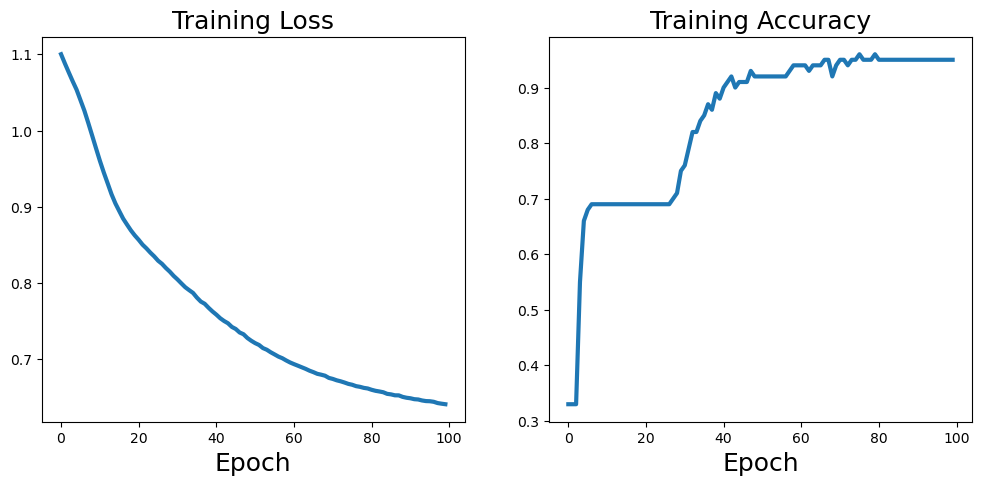

In [14]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(torch.arange(epoch),training_loss, lw=3)
plt.xlabel("Epoch", size=18)
plt.title("Training Loss", size=18)

plt.subplot(1,2,2)
plt.plot(torch.arange(epoch),training_accuracy, lw=3)
plt.xlabel("Epoch", size=18)
plt.title("Training Accuracy", size=18)

## Evaluating model

In [15]:
Test_X_Norm = torch.from_numpy(((Test_X - Test_X.mean())/Test_X.std())).to(torch.float32)
Test_X_Norm.shape

torch.Size([50, 4])

In [16]:
Test_Y = torch.from_numpy(Test_Y)

In [17]:
prediction = mlp(Test_X_Norm)
correct = (torch.argmax(prediction, dim=1) == Test_Y).to(torch.float32)
accuracy = correct.mean().item()
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 98.00%


## Saving and reloading

In [18]:
path = "iris_model.pt"
torch.save(mlp, path)

In [19]:
test_model = torch.load(path)
test_model.eval()

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [20]:
for i,j in test_model.named_parameters():
    print(i, j)
    print()

layer1.weight Parameter containing:
tensor([[ 1.0732, -1.2491,  2.7906,  0.6140],
        [-1.0326,  2.0607, -2.6750, -0.2634],
        [-0.0197,  0.1841, -2.2632, -1.5088],
        [ 0.2446, -1.3918,  2.1566,  0.9878],
        [ 0.3711,  0.1218,  1.3540,  0.3480],
        [ 0.0532,  1.2750,  0.3981,  0.0514],
        [ 0.9247, -1.1286,  2.1491,  0.3506],
        [ 0.1452,  0.0698, -2.0426, -0.7417],
        [-0.2780,  0.1760, -2.0116, -1.7401],
        [ 0.4581,  0.2396,  1.5070,  1.0682],
        [-0.3714,  1.7968, -2.0103, -0.5754],
        [-0.6650,  0.8885, -2.1305, -0.9599],
        [ 0.1586,  0.0768, -2.0351, -1.2917],
        [ 0.1119, -0.0533, -2.1682, -0.8691],
        [ 0.1059,  1.0868,  0.8601,  0.4806],
        [ 0.7465, -1.3169,  2.5337,  0.4740]], requires_grad=True)

layer1.bias Parameter containing:
tensor([ 0.6568, -0.1330,  0.1160,  0.7362, -0.4385, -0.0979, -0.1904,  0.0833,
        -0.0039, -0.1646, -0.3208,  0.4050, -0.2467,  0.3425,  0.2132,  0.1209],
       requ